In [1]:
from copy import deepcopy
import os
import random
import sys

In [2]:
from matplotlib.ticker import PercentFormatter
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as SciOpt
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.precision', 2)

In [146]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lcm.model.builder import LearnedCostModelBuilder, ClassicModel, FlexibleModel
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneGenerator
from endure.lsm.types import Policy, LSMDesign, System
from endure.lsm.cost import EndureCost
import endure.lsm.cost_model as CostFunc

In [148]:
model_path = '/data/models/lcm/kcost-06-09-v0'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [149]:
lsm_design

'KLSM'

In [150]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design == 'QLSM':
    gen = Gen.QCostGenerator(config)
else:
    gen = ClassicGenerator(config)
cf = EndureCost(config)

# Loss Graph

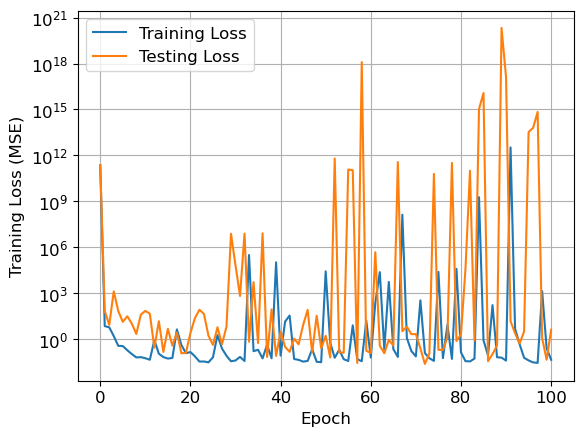

In [151]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
_ = ax.legend()

In [152]:
losses

,epoch,train_loss,test_loss
0,0,"222,811,089,152.00","222,811,089,152.00"
1,1,6.66,65.57
2,2,5.56,7.96
3,3,1.48,"1,251.65"
4,4,0.34,65.15
...,...,...,...
96,96,0.03,"62,092,553,912,320.00"
97,97,0.03,"683,371,604,738,048.00"
98,98,"1,298.81",1.10
99,99,0.24,0.04


# Building

## Model

In [153]:
# model_name = os.path.join(model_path, 'best.model')
model_name = os.path.join(model_path, 'checkpoints/epoch_10.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)

builder = LearnedCostModelBuilder(config)
model = builder.build_model()
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [154]:
model

FlexibleModel(
  (embedding): Sequential(
    (0): Linear(in_features=49, out_features=64, bias=True)
  )
  (cost_layer): Sequential(
    (0): BatchNorm1d(1354, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1354, out_features=512, bias=True)
    (2): Dropout(p=0, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Dropout(p=0, inplace=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=512, out_features=512, bias=True)
    (8): Dropout(p=0, inplace=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Dropout(p=0, inplace=False)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Linear(in_features=512, out_features=512, bias=True)
    (14): Dropout(p=0, inplace=False)
    (15): LeakyReLU(negative_slope=0.01)
    (16): Linear(in_features=512, out_features=512, bias=True)
    (17): 

# Utils

In [155]:
def to_array(workload: dict):
    return np.array([workload[x] for x in ('z0', 'z1', 'q', 'w')])

In [156]:
def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

In [157]:
def create_classic_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    T = design.T - config['lsm']['size_ratio']['min']
    T = np.eye(categories, dtype=np.int32)[T]
    policy = np.eye(2, dtype=np.int32)[design.policy.value]
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), policy, T))
    
    return inputs

In [158]:
def create_qlsm_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    one_hot_matrix = np.eye(categories, dtype=np.int32)
    T = design.T - config['lsm']['size_ratio']['min']
    T = one_hot_matrix[T]
    Q = design.Q - 1
    Q = one_hot_matrix[Q]
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), T, Q))
    
    return inputs

In [159]:
def create_klsm_input(design, system):
    categories = config['lsm']['size_ratio']['max'] - config['lsm']['size_ratio']['min'] + 1
    one_hot_matrix = np.eye(categories, dtype=np.int32)
    T = design.T - config['lsm']['size_ratio']['min']
    T = one_hot_matrix[T]
    capacities = (cap - 1 for cap in design.K)
    one_hot_cap = (one_hot_matrix[cap] for cap in capacities)
    k = np.array(list(one_hot_cap)).flatten()
    feats = [z0, z1, q, w, system.B, system.s, system.E, system.H, system.N, design.h]
    inputs = np.concatenate((np.array(feats), T, k))
    
    return inputs

In [188]:
def eval_lcm(design, system, z0, z1, q, w):
    if design.policy == Policy.KHybrid:
        inputs = create_klsm_input(design, system)
    elif design.policy in (Policy.Tiering, Policy.Leveling):
        inputs = create_classic_input(design, system)
    elif design.policy == Policy.QFixed:
        inputs = create_qlsm_input(design, system)
    
    inputs = torch.from_numpy(inputs).to(torch.float).view(1, -1)
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item()
    return pred

In [189]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
cf.calc_cost(design, system, z0, z1, q, w), eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=5.996, T=18, policy=<Policy.KHybrid: 2>, Q=1.0, Y=1.0, Z=1.0, K=[10, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
System(E=2048, s=4.2315184696153735e-07, B=64.0, N=489908427, H=7.914190064231507, phi=1.0)


(14.120675161709553, -12.839381217956543)

## Learned-Cost-Model Estimation To Analytical

### Single Variable Estimation

In [15]:
def generate_single_var_estimation(wl, system=None):
    if system is None:
        system = System()
    (z0, z1, q, w) = wl
    table = []
    design = LSMDesign(h=2, T=10, policy=Policy.Tiering)
    # for val in tqdm(np.arange(2, 50, 1)):
    #     design.T = val
    for val in tqdm(np.arange(0, 9, 0.1)):
        design.h = val
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            "policy": 1 if design.policy == Policy.Leveling else 0,
            'T': design.T,
            "cost_lcm": cost_lcm,
            "cost_acm": cost_acm,
        }
        table.append(row)
    table = pd.DataFrame(table)
    
    return table

In [16]:
idx = 4
df = generate_single_var_estimation(to_array(config['workloads'][idx]))

  0%|          | 0/90 [00:00<?, ?it/s]

In [17]:
df['delta'] = abs(df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)
df.describe()

,z0,z1,q,w,B,s,E,H,N,h,policy,T,cost_lcm,cost_acm,delta,norm_delta
count,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00,90.00
mean,0.01,0.01,0.01,0.97,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",4.45,0.00,10.00,2.14,2.16,0.06,0.03
std,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.61,0.00,0.00,0.08,0.11,0.04,0.02
min,0.01,0.01,0.01,0.97,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",0.00,0.00,10.00,2.01,2.06,0.00,0.00
25%,0.01,0.01,0.01,0.97,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",2.23,0.00,10.00,2.06,2.08,0.03,0.02
50%,0.01,0.01,0.01,0.97,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",4.45,0.00,10.00,2.18,2.11,0.06,0.03
75%,0.01,0.01,0.01,0.97,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",6.68,0.00,10.00,2.20,2.22,0.09,0.04
max,0.01,0.01,0.01,0.97,4.00,0.00,"8,192.00",10.00,"1,000,000,000.00",8.90,0.00,10.00,2.31,2.49,0.18,0.07


{'id': 4, 'z0': 0.01, 'z1': 0.01, 'q': 0.01, 'w': 0.97}

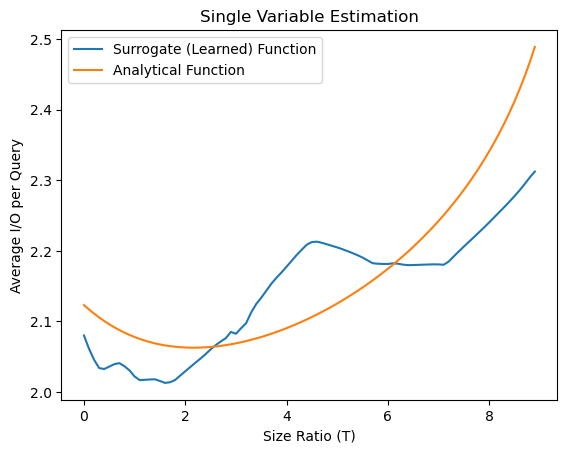

In [18]:
x = df['h']
y_learned = df['cost_lcm']
y_analytical = df['cost_acm']

fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
config['workloads'][idx]

### Random Configuration Estimation

In [19]:
def generate_random_samples(num_samples=100):
    table = []
    for _ in tqdm(range(num_samples)):
        z0, z1, q, w = gen._sample_workload(4)
        system = gen._sample_system()
        design = gen._sample_design(system, policies=[Policy.Tiering, Policy.Leveling])
        cost_lcm = eval_lcm(design, system, z0, z1, q, w)
        cost_acm = cf.calc_cost(design, system, z0, z1, q, w)
        row = {
            "z0": z0,
            "z1": z1,
            "q": q,
            "w": w,
            "B": system.B,
            "s": system.s,
            "E": system.E,
            "H": system.H,
            "N": system.N,
            'h': design.h,
            "policy": 1 if design.policy == Policy.Leveling else 0,
            'T': design.T,
            "cost_lcm": cost_lcm,
            "cost_acm": cost_acm,
        }
        table.append(row)
    table = pd.DataFrame(table)
    
    return table

In [20]:
num_samples = 10000
df = generate_random_samples(num_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
df['delta'] = df['cost_acm'] - df['cost_lcm']
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,policy,T,cost_lcm,cost_acm,delta,norm_delta
7346,0.88,0.02,0.00,0.09,16.00,0.00,4096,15.36,835813996,10.22,0,4,0.12,0.16,0.04,0.24
4851,0.88,0.01,0.00,0.11,64.00,0.00,2048,7.65,303012705,3.63,1,32,0.25,0.29,0.04,0.14
9884,0.17,0.16,0.01,0.67,64.00,0.00,1024,6.98,586065906,4.94,0,4,0.51,0.56,0.05,0.10
5769,0.22,0.11,0.00,0.67,16.00,0.00,4096,12.88,129968999,5.70,0,10,0.54,0.60,0.06,0.10
3375,0.84,0.05,0.01,0.10,64.00,0.00,1024,11.90,910810593,8.85,1,30,0.21,0.23,0.02,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7509,0.54,0.35,0.00,0.11,8.00,0.00,4096,15.38,393496677,2.35,1,4,1.13,1.00,-0.13,-0.13
8816,0.80,0.03,0.00,0.17,64.00,0.00,2048,6.92,809290679,0.51,1,49,1.07,0.94,-0.13,-0.14
3557,0.62,0.21,0.00,0.17,32.00,0.00,1024,17.67,378973934,16.51,0,18,0.34,0.29,-0.04,-0.15
8492,0.48,0.00,0.00,0.52,64.00,0.00,2048,12.54,382286239,8.52,1,2,0.25,0.20,-0.05,-0.23


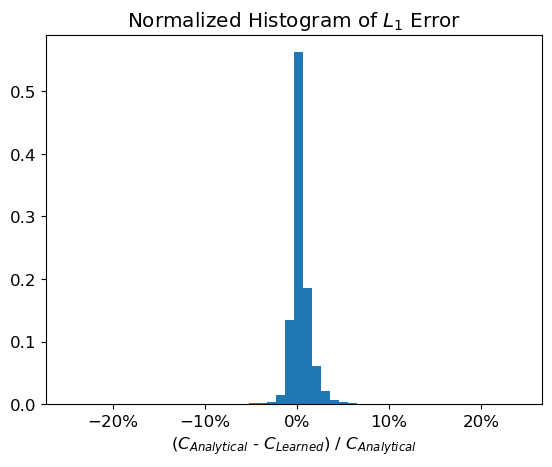

In [22]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
data = df['norm_delta'].values
ax.hist(data, bins=50, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))